##Class

In [1]:
import numpy as np

class MinNormSolver:
    MAX_ITER = 250
    STOP_CRIT = 1e-6

    def _min_norm_element_from2(v1v1, v1v2, v2v2):
        """
        Analytical solution for min_{c} |cx_1 + (1-c)x_2|_2^2
        d is the distance (objective) optimzed
        v1v1 = <x1,x1>
        v1v2 = <x1,x2>
        v2v2 = <x2,x2>
        """
        if v1v2 >= v1v1:
            # Case: Fig 1, third column
            gamma = 0.999
            cost = v1v1
            return gamma, cost
        if v1v2 >= v2v2:
            # Case: Fig 1, first column
            gamma = 0.001
            cost = v2v2
            return gamma, cost
        # Case: Fig 1, second column
        gamma = -1.0 * ( (v1v2 - v2v2) / (v1v1+v2v2 - 2*v1v2) )
        cost = v2v2 + gamma*(v1v2 - v2v2)
        return gamma, cost

    def _min_norm_2d(vecs, dps):
        """
        Find the minimum norm solution as combination of two points
        This solution is correct if vectors(gradients) lie in 2D
        ie. min_c |\sum c_i x_i|_2^2 st. \sum c_i = 1 , 1 >= c_1 >= 0 for all i, c_i + c_j = 1.0 for some i, j
        """
        dmin = 1e8
        for i in range(len(vecs)):
            for j in range(i+1,len(vecs)):
                if (i,j) not in dps:
                    dps[(i, j)] = 0.0
                    dps[(i,j)] = np.dot(vecs[i], vecs[j])
                    dps[(j, i)] = dps[(i, j)]
                if (i,i) not in dps:
                    dps[(i, i)] = 0.0
                    dps[(i,i)] = np.dot(vecs[i], vecs[i])
                if (j,j) not in dps:
                    dps[(j, j)] = 0.0   
                    dps[(j, j)] = np.dot(vecs[j], vecs[j])
                c,d = MinNormSolver._min_norm_element_from2(dps[(i,i)], dps[(i,j)], dps[(j,j)])
                if d < dmin:
                    dmin = d
                    sol = [(i,j),c,d]
        return sol, dps

    def _projection2simplex(y):
        """
        Given y, it solves argmin_z |y-z|_2 st \sum z = 1 , 1 >= z_i >= 0 for all i
        """
        m = len(y)
        sorted_y = np.flip(np.sort(y), axis=0)
        tmpsum = 0.0
        tmax_f = (np.sum(y) - 1.0)/m
        for i in range(m-1):
            tmpsum+= sorted_y[i]
            tmax = (tmpsum - 1)/ (i+1.0)
            if tmax > sorted_y[i+1]:
                tmax_f = tmax
                break
        return np.maximum(y - tmax_f, np.zeros(y.shape))
    
    def _next_point(cur_val, grad, n):
        proj_grad = grad - ( np.sum(grad) / n )
        tm1 = -1.0*cur_val[proj_grad<0]/proj_grad[proj_grad<0]
        tm2 = (1.0 - cur_val[proj_grad>0])/(proj_grad[proj_grad>0])
        
        skippers = np.sum(tm1<1e-7) + np.sum(tm2<1e-7)
        t = 1
        if len(tm1[tm1>1e-7]) > 0:
            t = np.min(tm1[tm1>1e-7])
        if len(tm2[tm2>1e-7]) > 0:
            t = min(t, np.min(tm2[tm2>1e-7]))

        next_point = proj_grad*t + cur_val
        next_point = MinNormSolver._projection2simplex(next_point)
        return next_point

    def find_min_norm_element(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the projected gradient descent until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)
        
        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]
    
        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]
                
        while iter_count < MinNormSolver.MAX_ITER:
            grad_dir = -1.0*np.dot(grad_mat, sol_vec)
            new_point = MinNormSolver._next_point(sol_vec, grad_dir, n)
            # Re-compute the inner products for line search
            v1v1 = 0.0
            v1v2 = 0.0
            v2v2 = 0.0
            for i in range(n):
                for j in range(n):
                    v1v1 += sol_vec[i]*sol_vec[j]*dps[(i,j)]
                    v1v2 += sol_vec[i]*new_point[j]*dps[(i,j)]
                    v2v2 += new_point[i]*new_point[j]*dps[(i,j)]
            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec + (1-nc)*new_point
            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec   
        return sol_vec, nd


#VD1

In [2]:
import numpy as np
from autograd import grad
import autograd.numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def f1(x):
    return (x[0]**2+x[1]**2+3)/(1+2*x[0]+8*x[1])
def f2(x):
    return (x[0]**2+x[1]**2+3)/(1+2*x[1]+8*x[0])

def g1(x):
    return x[0]**2+2*x[1]*x[0]-4
def g2(x):
    return x[0]
def g3(x):
    return x[1]

f1_dx = grad(f1)
f2_dx = grad(f2)
g1_dx = grad(g1)
g2_dx = grad(g2)
g3_dx = grad(g3)

cons = ({'type': 'ineq',
          'fun' : lambda x: np.array([g1(x)])},
         {'type': 'ineq',
          'fun' : lambda x: np.array([g2(x)])},
          {'type': 'ineq',
          'fun' : lambda x: np.array([g3(x)])})

def rosen(x,y):
    """The Rosenbrock function"""
    return np.sqrt(np.sum((x-y)**2))

def find_min(y,n):
    x = np.random.rand(1,n).tolist()[0]
    res = minimize(rosen, x, args=(y), jac="2-point",
                constraints=cons,method='SLSQP', options={'disp': False})
    return res.x

In [ ]:
import autograd.numpy as np
from autograd import grad

from matplotlib import pyplot as plt

# use autograd to calculate the gradient
import autograd.numpy as np
from autograd import grad
from scipy.linalg import norm
from matplotlib import pyplot as plt

def get_d_paretomtl(grads,value, constraint,weights,i):
    # calculate the gradient direction for Pareto MTL
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
       
    # solve QP 
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0

    test = np.concatenate((grads, np.dot(w[idx],grads)), axis = 0)
    if test.ndim == constraint.ndim:
      vec =  np.concatenate((test, constraint), axis = 0)
    else:
      vec = test
    
    vec = vec/norm(vec)

    # use MinNormSolver to solve QP
    sol, nd = MinNormSolver.find_min_norm_element(vec)
    
    # reformulate ParetoMTL as linear scalarization method, return the weights
    weight0 =  sol[0] + np.sum(np.array([sol[j] * w[idx][j - 2,0] for j in np.arange(2,2 + np.sum(idx))]))
    weight1 = sol[1] + np.sum(np.array([sol[j] * w[idx][j - 2,1] for j in np.arange(2,2 + np.sum(idx))]))

    num_cons = len(constraint)
    if num_cons != 0:
      weight_cons = sol[-num_cons:]
      weight = np.array(list([weight0]) + list([weight1]) + weight_cons)
    else:
      weight = np.stack([weight0, weight1])
    return weight


def get_d_paretomtl_init(grads,value,constraint, weights,i):
    # calculate the gradient direction for Pareto MTL initialization
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
    
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0
    
    if np.sum(idx) <= 0:
        return np.zeros(nobj)
    if np.sum(idx) == 1:
        sol = np.ones(1)
    else:
        test = np.dot(w[idx],grads)
        if constraint.ndim == test.ndim:
          vec =  np.concatenate((test, constraint), axis = 0)
        else:
          vec = test
        vec = vec/norm(vec)
        
        sol, nd = MinNormSolver.find_min_norm_element(vec)
    
    # calculate the weights
    weight0 =  np.sum(np.array([sol[j] * w[idx][j ,0] for j in np.arange(0, np.sum(idx))]))
    weight1 =  np.sum(np.array([sol[j] * w[idx][j ,1] for j in np.arange(0, np.sum(idx))]))

    num_cons = len(constraint)
    if num_cons != 0:
      weight_cons = sol[-num_cons:]
      weight = np.array(list([weight0]) + list([weight1]) + weight_cons)
    else:
      weight = np.stack([weight0, weight1])

    return weight


def circle_points(r, n):
    # generate evenly distributed preference vector
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

def circle_points2(K, min_angle=None, max_angle=None):
    # generate evenly distributed preference vector
    ang0 = np.pi / 30. if min_angle is None else min_angle
    ang1 = np.pi * 8 / 20. if max_angle is None else max_angle
    angles = np.linspace(ang0, ang1, K, endpoint=True)
    x = np.cos(angles)
    y = np.sin(angles)
    return np.c_[x, y]


# calculate the gradients using autograd
f1_dx = grad(f1)
f2_dx = grad(f2)


def pareto_mtl_search(ref_vecs,i, t_iter = 100, n_dim = 2, step_size = 2, sigma = 1, kappa = 0.95, eps = 0.01, count_check = 10):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(0, 1, n_dim)
    x = find_min(x, 2)
    f_all = []
    x_all = []
    df_all = []

    # find the initial solution
    for t in range(int(t_iter * 0.2)):
        f, f_dx = concave_fun_eval(x)
        # f, f_dx = convex_fun_eval(x)
        constraint = []
        value_set = [[g1(x),g1_dx(x)], [g2(x),g2_dx(x)], [g3(x),g3_dx(x)]]
        for f_value in value_set:
          if f_value[0]<=eps:
            constraint.append(-f_value[1])
        constraint = np.array(constraint)
        weights =  get_d_paretomtl_init(f_dx,f, constraint, ref_vecs,i)

        if len(weights) > len(f_dx):
          direction_descent = -np.dot(weights[0:len(f_dx)].T,f_dx).flatten() - np.dot(weights[len(f_dx):].T, constraint).flatten()
        else:
          direction_descent = -np.dot(weights.T,f_dx).flatten()
          
        x = x + step_size * direction_descent
        x = find_min(x, n_dim)
        x_all.append(x)
    
    count = 0
    # find the Pareto optimal solution
    for t in range(int(t_iter * 0.8)):
        #f, f_dx = convex_fun_eval(x)
        f, f_dx = concave_fun_eval(x)
        f_all.append(f)
        df_all.append(f_dx)
        constraint = []
        value_set = [[g1(x),g1_dx(x)], [g2(x),g2_dx(x)], [g3(x),g3_dx(x)]]
        for f_value in value_set:
          if f_value[0]<=eps:
            constraint.append(-f_value[1])
        constraint = np.array(constraint)

        weights =  get_d_paretomtl(f_dx,f,constraint, ref_vecs,i)
        
        if len(weights) > len(f_dx):
          direction_descent = -np.dot(weights[0:len(f_dx)].T,f_dx).flatten() - np.dot(weights[len(f_dx):].T, constraint).flatten()
          x_next = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k
          #x_next = find_min(x_next, n_dim)
          f_after, f_dx_after = concave_fun_eval(x_next)
          #f_after, f_dx_after = convex_fun_eval(x_next)
          
          if np.dot(weights[0:len(f_dx)].T,f_after).flatten() + np.dot(weights[len(f_dx):].T, constraint).flatten() <= np.dot(weights[0:len(f_dx)].T,f).flatten() - np.dot(weights[len(f_dx):].T, constraint).flatten() + sigma*np.dot(direction_descent.T, step_size * direction_descent):
            step_size *= kappa
        else:
          direction_descent = -np.dot(weights.T,f_dx).flatten()
          x_next = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k
          #x_next = find_min(x_next, n_dim)
          f_after, f_dx_after = concave_fun_eval(x_next)
          #f_after, f_dx_after = convex_fun_eval(x_next)
          
          if np.dot(weights.T,f_after) <= np.dot(weights.T, f) + sigma*np.dot(direction_descent.T, step_size * direction_descent):
            step_size *= kappa

        if -1/2*norm(direction_descent)**2 >= -0.01 or -1/2*norm(direction_descent)**2 <= 0.01:
          break
      
        x = x + step_size * direction_descent
        #x = find_min(x, n_dim)
        x_all.append(x)

    return x, f, x_all, f_all, df_all


In [ ]:
!pip install pymoo

In [ ]:
from pymoo.factory import get_performance_indicator
from pymoo.indicators.hv import HV
import numpy as np

def hypervolumn(A, ref=None, type='acc'):
    """
    :param A: np.array, num_points, num_task
    :param ref: num_task
    """
    dim = A.shape[1]

    if type == 'acc':
        if ref is None:
            ref = np.zeros(dim)
        hv = HV(ref_point=ref)
        return hv.do(-A)

    elif type == 'loss':
        if ref is None:
            ref = np.ones(dim)
        hv = get_performance_indicator("hv",ref_point=ref)
        return hv.do(A)
    else:
        print('type not implemented')
        return None

def get_pareto_front(A, type='acc'):
    """
    Get dominated point
    :param A: np.array, num_points, dim
    :param ref: dim
    """
    if A.shape[0] == 0:
        return A

    pareto_front = []
    if type == 'acc':
        for _ in range(A.shape[0]):
            if not (((A - A[_, :]) > 0).sum(axis=1) == A.shape[1]).sum():
                pareto_front.append(list(A[_, :]))
    elif type == 'loss':
        for _ in range(A.shape[0]):
            if not (((A - A[_, :]) < 0).sum(axis=1) == A.shape[1]).sum():
                pareto_front.append(list(A[_, :]))

    return pareto_front
    # return np.array(pareto_front)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


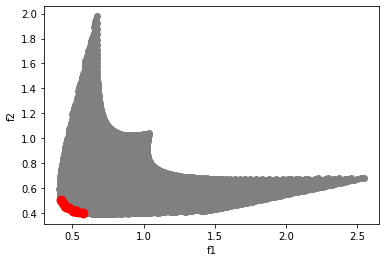

In [ ]:
def concave_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f1(x), f2(x)]), np.stack([f1_dx(x), f2_dx(x)])
    
### create the ground truth Pareto front ###
def create_pf_concave():
    ps = np.linspace(0, 5, 100)
    pf = []
    
    for x1 in ps:
      for x2 in ps:
        if 4-x1**2-2*x1*x2<=0:
          x = np.array([x1, x2])
          f, f_dx = concave_fun_eval(x)
          pf.append(f)
            
    pf = np.array(pf)
    
    return pf

pf = create_pf_concave()
f_value_list = []
x_value_list = []
num = 20

# weights = circle_points([1], [num])[0]
weights = circle_points2(num)

for i in range(num):
        
    print(i)
        
    x, f, x_all, f_all, df_all = pareto_mtl_search(ref_vecs = weights,i = i)
    
    # x = find_min(x, 2)
    if x[0] >= 0  and x[1] >= 0 and x[0]**2 +2 *x[0]*x[1] -4 >=0:
      f_value_list.append(f)
      x_value_list.append(x)  

f_value = np.array(f_value_list)
plt.xlabel("f1")
plt.ylabel("f2")
plt.scatter(pf[:,0],pf[:,1], c = 'gray')
plt.scatter(f_value[:,0], f_value[:,1], c = 'r', s = 80)
plt.show()

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.hv import Hypervolume

hv = Hypervolume(ref_point=np.array([1, 1]))

In [ ]:
hv(f_value)

0.3403019313898456

#Version 2 VD1

In [ ]:
import autograd.numpy as np
from autograd import grad

from matplotlib import pyplot as plt

# use autograd to calculate the gradient
import autograd.numpy as np
from autograd import grad
from scipy.linalg import norm
from matplotlib import pyplot as plt

def get_d_moomtl(grads, constraint):
    """
    calculate the gradient direction for MOO-MTL 
    """
    
    nobj, dim = grads.shape

    if constraint.ndim == grads.ndim:
      vec =  np.concatenate((grads, constraint), axis = 0)
    else:
      vec = grads
    vec = vec/norm(vec)
    
    sol, nd = MinNormSolver.find_min_norm_element(vec)
    
    return sol


def circle_points(r, n):
    # generate evenly distributed preference vector
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

def circle_points2(K, min_angle=None, max_angle=None):
    # generate evenly distributed preference vector
    ang0 = np.pi / 30. if min_angle is None else min_angle
    ang1 = np.pi * 8 / 20. if max_angle is None else max_angle
    angles = np.linspace(ang0, ang1, K, endpoint=True)
    x = np.cos(angles)
    y = np.sin(angles)
    return np.c_[x, y]


# calculate the gradients using autograd
f1_dx = grad(f1)
f2_dx = grad(f2)


def moo_mtl_search(ref_vecs,i,t_iter = 1000, n_dim = 2, step_size = 1, sigma = 1, kappa = 0.85, eps = 0.01, count_check = 10):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(0, 1, n_dim)
    x = find_min(x, 2)
    f_all = []
    x_all = []
    df_all = []

    # find the Pareto optimal solution
    for t in range(t_iter):
        #f, f_dx = convex_fun_eval(x)
        f, f_dx = concave_fun_eval(x)
        f_all.append(f)
        df_all.append(f_dx)
        constraint = []
        value_set = [[g1(x),g1_dx(x)], [g2(x),g2_dx(x)], [g3(x),g3_dx(x)]]
        for f_value in value_set:
          if f_value[0]<=eps:
            constraint.append(-f_value[1])
        constraint = np.array(constraint)
        weights =  get_d_moomtl(f_dx, constraint)
        
        if len(weights) > len(f_dx):
          direction_descent = -np.dot(weights[0:len(f_dx)].T,f_dx).flatten() - np.dot(weights[len(f_dx):].T, constraint).flatten()
        else:
          direction_descent = -np.dot(weights.T,f_dx).flatten()
        if -1/2*norm(direction_descent)**2 >= -0.01 or -1/2*norm(direction_descent)**2 <= 0.01:
          break
        x_next = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k
        #x_next = find_min(x_next, n_dim)
        f_after, f_dx_after = concave_fun_eval(x_next)
        #f_after, f_dx_after = convex_fun_eval(x_next)
        
        if np.dot(weights.T,f_after) <= np.dot(weights.T, f) + sigma*np.dot(direction_descent.T, step_size * direction_descent):
          step_size *= kappa

        x = x + step_size * direction_descent
        #x = find_min(x, n_dim)
        x_all.append(x)

    return x, f, x_all, f_all, df_all


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


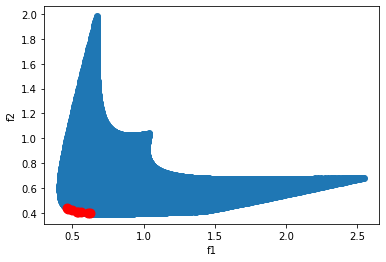

In [ ]:
def concave_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f1(x), f2(x)]), np.stack([f1_dx(x), f2_dx(x)])
    
### create the ground truth Pareto front ###
def create_pf_concave():
    ps = np.linspace(0, 5, 100)
    pf = []
    
    for x1 in ps:
      for x2 in ps:
        if 4-x1**2-2*x1*x2<=0:
          x = np.array([x1, x2])
          f, f_dx = concave_fun_eval(x)
          pf.append(f)
            
    pf = np.array(pf)
    
    return pf

# pf = create_pf_concave()
f_value_list = []
x_value_list = []
num = 20

weights = circle_points([1], [num])[0]
#weights = circle_points2(num)

for i in range(num):
        
    print(i)
        
    x, f, x_all, f_all, df_all = moo_mtl_search(ref_vecs = weights,i = i)
    
    x = find_min(x, 2)
    if x[0] >= 0  and x[1] >= 0 and x[0]**2 +2 *x[0]*x[1] -4 >=0:
      f_value_list.append(f)
      x_value_list.append(x)  

f_value = np.array(f_value_list)
plt.xlabel("f1")
plt.ylabel("f2")
plt.scatter(pf[:,0],pf[:,1])
plt.scatter(f_value[:,0], f_value[:,1], c = 'r', s = 80)
plt.show()

#VD2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Hyper volume:  2.982623598975567


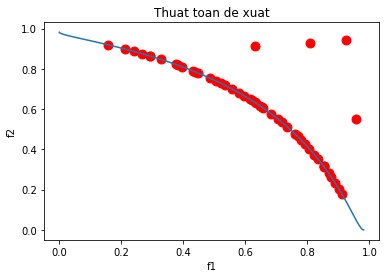

CPU times: user 2min 21s, sys: 1.46 s, total: 2min 22s
Wall time: 2min 24s


In [ ]:
%%time
# use autograd to calculate the gradient
import autograd.numpy as np
from autograd import grad
from math import e
from matplotlib import pyplot as plt


def get_d_paretomtl(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
    
    
    # solve QP 
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0
   
    vec =  np.concatenate((grads, np.dot(w[idx],grads)), axis = 0)
    
    # use MinNormSolver to solve QP
    sol, nd = MinNormSolver.find_min_norm_element(vec)
   
    
    # reformulate ParetoMTL as linear scalarization method, return the weights
    weight0 =  sol[0] + np.sum(np.array([sol[j] * w[idx][j - 2,0] for j in np.arange(2,2 + np.sum(idx))]))
    weight1 = sol[1] + np.sum(np.array([sol[j] * w[idx][j - 2,1] for j in np.arange(2,2 + np.sum(idx))]))
    weight = np.stack([weight0,weight1])
   
    return weight


def get_d_paretomtl_init(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL initialization
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
    
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0
    
    if np.sum(idx) <= 0:
        return np.zeros(nobj)
    if np.sum(idx) == 1:
        sol = np.ones(1)
    else:
        vec =  np.dot(w[idx],grads)
        sol, nd = MinNormSolver.find_min_norm_element(vec)

    # calculate the weights
    weight0 =  np.sum(np.array([sol[j] * w[idx][j ,0] for j in np.arange(0, np.sum(idx))]))
    weight1 =  np.sum(np.array([sol[j] * w[idx][j ,1] for j in np.arange(0, np.sum(idx))]))
    weight = np.stack([weight0,weight1])
   

    return weight


# def circle_points(r, n):
#     # generate evenly distributed preference vector
#     circles = []
#     for r, n in zip(r, n):
#         t = np.linspace(0, 0.5 * np.pi, n)
#         x = r * np.cos(t)
#         y = r * np.sin(t)
#         circles.append(np.c_[x, y])
#     return circles

def circle_points(K, min_angle=None, max_angle=None):
    # generate evenly distributed preference vector
    ang0 = np.pi / 20. if min_angle is None else min_angle
    ang1 = np.pi * 9 / 20. if max_angle is None else max_angle
    angles = np.linspace(ang0, ang1, K, endpoint=True)
    x = np.cos(angles)
    y = np.sin(angles)
    return np.c_[x, y]

### the synthetic multi-objective problem ###
def f1(x):
    
    n = len(x)
    
    sum1 = np.sum([(x[i] - 1.0/np.sqrt(n)) ** 2 for i in range(n)])

    f1 = 1 - e**(- sum1)
    return f1

def f2(x):
    
    n = len(x)
    
    sum2 = np.sum([(x[i] + 1.0/np.sqrt(n)) ** 2 for i in range(n)])
   
    f2 = 1 - e**(- sum2)
    
    return f2

def f3(x):
    #2 dims
    return 1/25*x[0]**2+1/100*(x[1]-9/2)**2
def f4(x):
    return 1/25*x[1]**2+1/100*(x[0]-9/2)**2

# calculate the gradients using autograd
f1_dx = grad(f1)
f2_dx = grad(f2)
f3_dx = grad(f3)
f4_dx = grad(f4)

def concave_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f1(x), f2(x)]), np.stack([f1_dx(x), f2_dx(x)])
    
def convex_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f3(x), f4(x)]), np.stack([f3_dx(x), f4_dx(x)])

### create the ground truth Pareto front ###
def create_pf_concave():
    ps = np.linspace(-1/np.sqrt(2),1/np.sqrt(2))
    pf = []
    
    for x1 in ps:
        #generate solutions on the Pareto front:
        x = np.array([x1,x1])
        
        f, f_dx = concave_fun_eval(x)
        pf.append(f)
            
    pf = np.array(pf)
    
    return pf


def create_pf1():
    ps1 = np.linspace(-6, 0, num=500)
    pf = []
    for x1 in ps1:
        x = [9*x1/(2*x1-8),9/(2-8*x1)]
        f = [f3(x), f4(x)]
        #print(f)
        pf.append(f)
    pf = np.array(pf)
    return pf

def pareto_mtl_search(ref_vecs,i,t_iter = 100, n_dim = 20, step_size = 2, sigma = 1, kappa = 0.95):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(-0.5,0.5,n_dim)
    #x = (np.random.rand(1,2)).tolist()[0]
    #x = np.random.uniform(-2,0,n_dim)
    #print(x.shape)
    # find the initial solution
    for t in range(int(t_iter * 0.2)):
        f, f_dx = concave_fun_eval(x)
        #f, f_dx = convex_fun_eval(x)

        weights =  get_d_paretomtl_init(f_dx,f,ref_vecs,i)
     
        x = x - step_size * np.dot(weights.T,f_dx).flatten()
    count =0 
    # find the Pareto optimal solution
    for t in range(int(t_iter * 0.8)):
        #f, f_dx = convex_fun_eval(x)
        f, f_dx = concave_fun_eval(x)

        weights =  get_d_paretomtl(f_dx,f,ref_vecs,i)
     
        direction_descent = -np.dot(weights.T,f_dx).flatten()

        x_next = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k
        
        f_after, f_dx_after = concave_fun_eval(x_next)
        #f_after, f_dx_after = convex_fun_eval(x_next)
        
        if np.dot(weights.T,f_after) <= np.dot(weights.T, f) + sigma*np.dot(direction_descent.T, step_size * direction_descent):
            step_size = step_size
            count+=1
        else:
            step_size *= kappa
        if -1/2*np.linalg.norm(direction_descent, np.inf)**2 >= -1e-8 and -1/2*np.linalg.norm(direction_descent, np.inf)**2 <= 1e-8:
          break
        x = x + step_size * direction_descent
    return x, f




def run(num = 50):
    """
    run method on the synthetic example
    method: optimization method {'ParetoMTL', 'MOOMTL', 'Linear'}
    num: number of solutions
    """
    
    pf = create_pf_concave()
    #pf = create_pf1()
    f_value_list = []
    
    weights = circle_points(num)
    
    for i in range(num):
        
        print(i)
        
        x, f = pareto_mtl_search(ref_vecs = weights,i = i)
        
        f_value_list.append(f)
        
    f_value = np.array(f_value_list)
    hv = Hypervolume(ref_point=np.array([2, 2]))
    print('Hyper volume: ',hv(f_value))
    plt.plot(pf[:,0],pf[:,1])
    plt.scatter(f_value[:,0], f_value[:,1], c = 'r', s = 80)
    plt.xlabel("f1")
    plt.ylabel("f2")
    plt.title("Thuat toan de xuat")
    plt.show()
    return f_value
    
f_value_vd1 = run()

In [ ]:
hv = Hypervolume(ref_point=np.array([1.5, 1.5]))
print('Hyper volume: ',hv(f_value_vd1))

Hyper volume:  1.3995837502163506


In [ ]:
f_value_vd1

array([[0.91229931, 0.17601021],
       [0.85410166, 0.31575116],
       [0.90111614, 0.20497576],
       [0.88875175, 0.23547186],
       [0.87686231, 0.26335405],
       [0.86845573, 0.2822365 ],
       [0.85497865, 0.31114041],
       [0.85280406, 0.3156729 ],
       [0.83515412, 0.35092041],
       [0.82311005, 0.37359016],
       [0.80631414, 0.4035662 ],
       [0.79125026, 0.42882792],
       [0.78103103, 0.44528381],
       [0.76834956, 0.46491123],
       [0.95695271, 0.55236161],
       [0.75981616, 0.4776217 ],
       [0.73483264, 0.51280888],
       [0.71760059, 0.53549344],
       [0.70482099, 0.5515257 ],
       [0.92388221, 0.94148887],
       [0.68261089, 0.57803133],
       [0.65492002, 0.60872454],
       [0.65639883, 0.60716924],
       [0.64816728, 0.61571622],
       [0.6346864 , 0.62954594],
       [0.6309302 , 0.63330912],
       [0.61576957, 0.64817469],
       [0.62020111, 0.64396936],
       [0.5965099 , 0.66615965],
       [0.57958496, 0.68121688],
       [0.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Hyper volume:  1.43287302100474
CPU times: user 3min 19s, sys: 1.62 s, total: 3min 20s
Wall time: 3min 30s


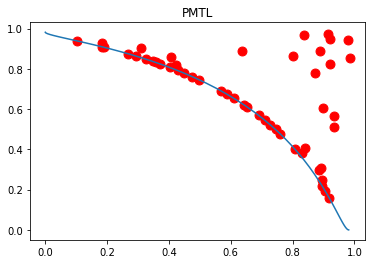

In [ ]:
%%time
# use autograd to calculate the gradient
import autograd.numpy as np
from autograd import grad

from matplotlib import pyplot as plt



### functions for solving QP problem  ###

# can use cvxopt or use the min_norm_solvers written by the author of MOO-MTL


#import cvxopt
#from cvxopt import matrix
#
#def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
#    P = .5 * (P + P.T)  # make sure P is symmetric
#    
#    P = P.astype(np.double)
#    q = q.astype(np.double)
#    args = [matrix(P), matrix(q)]
#    if G is not None:
#        args.extend([matrix(G), matrix(h)])
#        if A is not None:
#            args.extend([matrix(A), matrix(b)])
#    sol = cvxopt.solvers.qp(*args)
#    if 'optimal' not in sol['status']:
#        return None
#    return np.array(sol['x']).reshape((P.shape[1],))


def get_d_moomtl(grads):
    """
    calculate the gradient direction for MOO-MTL 
    """
    
    nobj, dim = grads.shape
    
#    # use cvxopt to solve QP
#    P = np.dot(grads , grads.T)
#    
#    q = np.zeros(nobj)
#    
#    G =  - np.eye(nobj)
#    h = np.zeros(nobj)
#    
#    
#    A = np.ones(nobj).reshape(1,2)
#    b = np.ones(1)
#       
#    cvxopt.solvers.options['show_progress'] = False
#    sol = cvxopt_solve_qp(P, q, G, h, A, b)
    
    # use MinNormSolver to solve QP
    sol, nd = MinNormSolver.find_min_norm_element(grads)
    
    return sol



def get_d_paretomtl(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
    
    
    # solve QP 
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0
   
    
    vec =  np.concatenate((grads, np.dot(w[idx],grads)), axis = 0)
    
#    # use cvxopt to solve QP
#    
#    P = np.dot(vec , vec.T)
#    
#    q = np.zeros(nobj + np.sum(idx))
#    
#    G =  - np.eye(nobj + np.sum(idx) )
#    h = np.zeros(nobj + np.sum(idx))
#    
#
#    
#    A = np.ones(nobj + np.sum(idx)).reshape(1,nobj + np.sum(idx))
#    b = np.ones(1)
 
#    cvxopt.solvers.options['show_progress'] = False
#    sol = cvxopt_solve_qp(P, q, G, h, A, b)
  
    # use MinNormSolver to solve QP
    sol, nd = MinNormSolver.find_min_norm_element(vec)
   
    
    # reformulate ParetoMTL as linear scalarization method, return the weights
    weight0 =  sol[0] + np.sum(np.array([sol[j] * w[idx][j - 2,0] for j in np.arange(2,2 + np.sum(idx))]))
    weight1 = sol[1] + np.sum(np.array([sol[j] * w[idx][j - 2,1] for j in np.arange(2,2 + np.sum(idx))]))
    weight = np.stack([weight0,weight1])
   

    return weight



def get_d_paretomtl_init(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL initialization
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
    
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0
    
    if np.sum(idx) <= 0:
        return np.zeros(nobj)
    if np.sum(idx) == 1:
        sol = np.ones(1)
    else:
        vec =  np.dot(w[idx],grads)
        sol, nd = MinNormSolver.find_min_norm_element(vec)

    # calculate the weights
    weight0 =  np.sum(np.array([sol[j] * w[idx][j ,0] for j in np.arange(0, np.sum(idx))]))
    weight1 =  np.sum(np.array([sol[j] * w[idx][j ,1] for j in np.arange(0, np.sum(idx))]))
    weight = np.stack([weight0,weight1])
   

    return weight



def circle_points(r, n):
    # generate evenly distributed preference vector
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles


### the synthetic multi-objective problem ###
def f1(x):
    
    n = len(x)
    
    sum1 = np.sum([(x[i] - 1.0/np.sqrt(n)) ** 2 for i in range(n)])

    f1 = 1 - np.exp(- sum1)
    return f1

def f2(x):
    
    n = len(x)
    
    sum2 = np.sum([(x[i] + 1.0/np.sqrt(n)) ** 2 for i in range(n)])
   
    f2 = 1 - np.exp(- sum2)
    
    return f2

# calculate the gradients using autograd
f1_dx = grad(f1)
f2_dx = grad(f2)
    
def concave_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f1(x), f2(x)]), np.stack([f1_dx(x), f2_dx(x)])
    
    
### create the ground truth Pareto front ###
def create_pf():
    ps = np.linspace(-1/np.sqrt(2),1/np.sqrt(2))
    pf = []
    
    for x1 in ps:
        #generate solutions on the Pareto front:
        x = np.array([x1,x1])
        
        f, f_dx = concave_fun_eval(x)
        pf.append(f)
            
    pf = np.array(pf)
    
    return pf




### optimization method ###

def linear_scalarization_search(t_iter = 100, n_dim = 20, step_size = 1):
    """
    linear scalarization with randomly generated weights
    """
    r = np.random.rand(1)
    weights = np.stack([r, 1-r])
    
    x = np.random.uniform(-0.5,0.5,n_dim)
    
    for t in range(t_iter):
        f, f_dx = concave_fun_eval(x)
        x = x - step_size * np.dot(weights.T,f_dx).flatten()
    
    return x, f


def moo_mtl_search(t_iter = 100, n_dim = 20, step_size = 1):
    """
    MOO-MTL
    """
    x = np.random.uniform(-0.5,0.5,n_dim)
    
    for t in range(t_iter):
        f, f_dx = concave_fun_eval(x)
    
        weights = get_d_moomtl(f_dx)
     
        
        x = x - step_size * np.dot(weights.T,f_dx).flatten()


    return x, f


def pareto_mtl_search(ref_vecs,i,t_iter = 100, n_dim = 20, step_size = 1):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(-0.5,0.5,n_dim)
    #x = (np.random.rand(1,2)).tolist()[0]
    #x = np.random.uniform(-2,0,n_dim)
    #print(x.shape)
    # find the initial solution
    for t in range(int(t_iter * 0.2)):
        f, f_dx = concave_fun_eval(x)
        #f, f_dx = convex_fun_eval(x)

        weights =  get_d_paretomtl_init(f_dx,f,ref_vecs,i)
     
        x = x - step_size * np.dot(weights.T,f_dx).flatten()
    
    # find the Pareto optimal solution
    for t in range(int(t_iter * 0.8)):
        #f, f_dx = convex_fun_eval(x)
        f, f_dx = concave_fun_eval(x)

        weights =  get_d_paretomtl(f_dx,f,ref_vecs,i)
     
        direction_descent = -np.dot(weights.T,f_dx).flatten()

        x = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k
        
    return x, f



def run(method = 'ParetoMTL', num = 50):
    """
    run method on the synthetic example
    method: optimization method {'ParetoMTL', 'MOOMTL', 'Linear'}
    num: number of solutions
    """
    
    pf = create_pf()
    f_value_list = []
    
    weights = circle_points([1], [num])[0]
    

    
    for i in range(num):
        
        print(i)
        
        if method == 'ParetoMTL':
            x, f = pareto_mtl_search(ref_vecs = weights,i = i)
        if method == 'MOOMTL':
            x, f = moo_mtl_search()
        if method == 'Linear':
            x, f = linear_scalarization_search()
        
        f_value_list.append(f)
        
       
    f_value = np.array(f_value_list)
    hv = Hypervolume(ref_point=np.array([1.5, 1.5]))
    print('Hyper volume: ',hv(f_value))
    plt.plot(pf[:,0],pf[:,1])
    plt.scatter(f_value[:,0], f_value[:,1], c = 'r', s = 80)
    plt.title('PMTL')
    return f_value

f_value_vd1_non = run('ParetoMTL')

In [ ]:
f_value_vd1_non

array([[0.8023855 , 0.86163855],
       [0.91904718, 0.15825721],
       [0.8964793 , 0.2499478 ],
       [0.83583262, 0.96597418],
       [0.90500982, 0.19517734],
       [0.83172942, 0.38280606],
       [0.83894652, 0.40583734],
       [0.89676385, 0.21584717],
       [0.88568639, 0.29759956],
       [0.87208752, 0.77773691],
       [0.89117073, 0.30874685],
       [0.93361421, 0.51304544],
       [0.93264095, 0.56783074],
       [0.88969817, 0.88710808],
       [0.80637976, 0.40337024],
       [0.91455797, 0.97467019],
       [0.89972862, 0.60325944],
       [0.76082677, 0.47602661],
       [0.7449685 , 0.49877393],
       [0.72700082, 0.52316821],
       [0.70979846, 0.54526323],
       [0.69063292, 0.56854975],
       [0.91996689, 0.94664645],
       [0.65282248, 0.61081924],
       [0.6438068 , 0.6202457 ],
       [0.97951599, 0.94409697],
       [0.60973777, 0.65384248],
       [0.58891777, 0.67292662],
       [0.56849424, 0.69067994],
       [0.98481524, 0.85423567],
       [0.

#VD3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Hyper volume:  0.8441172071587997


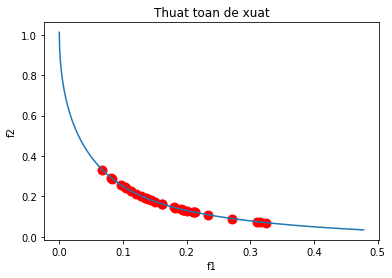

CPU times: user 3min 29s, sys: 2.69 s, total: 3min 31s
Wall time: 3min 34s


In [ ]:
%%time
# use autograd to calculate the gradient
import autograd.numpy as np
from autograd import grad
from math import e
from matplotlib import pyplot as plt


def get_d_paretomtl(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
    
    
    # solve QP 
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0
   
    vec =  np.concatenate((grads, np.dot(w[idx],grads)), axis = 0)
    
    # use MinNormSolver to solve QP
    sol, nd = MinNormSolver.find_min_norm_element(vec)
   
    
    # reformulate ParetoMTL as linear scalarization method, return the weights
    weight0 =  sol[0] + np.sum(np.array([sol[j] * w[idx][j - 2,0] for j in np.arange(2,2 + np.sum(idx))]))
    weight1 = sol[1] + np.sum(np.array([sol[j] * w[idx][j - 2,1] for j in np.arange(2,2 + np.sum(idx))]))
    weight = np.stack([weight0,weight1])
   
    return weight


def get_d_paretomtl_init(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL initialization
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
    
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0
    
    if np.sum(idx) <= 0:
        return np.zeros(nobj)
    if np.sum(idx) == 1:
        sol = np.ones(1)
    else:
        vec =  np.dot(w[idx],grads)
        sol, nd = MinNormSolver.find_min_norm_element(vec)

    # calculate the weights
    weight0 =  np.sum(np.array([sol[j] * w[idx][j ,0] for j in np.arange(0, np.sum(idx))]))
    weight1 =  np.sum(np.array([sol[j] * w[idx][j ,1] for j in np.arange(0, np.sum(idx))]))
    weight = np.stack([weight0,weight1])
   

    return weight


def circle_points(r, n):
    # generate evenly distributed preference vector
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

# def circle_points(K, min_angle=None, max_angle=None):
#     # generate evenly distributed preference vector
#     ang0 = np.pi / 20. if min_angle is None else min_angle
#     ang1 = np.pi * 9 / 20. if max_angle is None else max_angle
#     angles = np.linspace(ang0, ang1, K, endpoint=True)
#     x = np.cos(angles)
#     y = np.sin(angles)
#     return np.c_[x, y]

### the synthetic multi-objective problem ###
# def f1(x):
    
#     n = len(x)
    
#     sum1 = np.sum([(x[i] - 1.0/np.sqrt(n)) ** 2 for i in range(n)])

#     f1 = 1 - e**(- sum1)
#     return f1

# def f2(x):
    
#     n = len(x)
    
#     sum2 = np.sum([(x[i] + 1.0/np.sqrt(n)) ** 2 for i in range(n)])
   
#     f2 = 1 - e**(- sum2)
    
#     return f2

def f3(x):
    #2 dims
    return 1/25*x[0]**2+1/100*(x[1]-9/2)**2
def f4(x):
    return 1/25*x[1]**2+1/100*(x[0]-9/2)**2

# calculate the gradients using autograd
# f1_dx = grad(f1)
# f2_dx = grad(f2)
f3_dx = grad(f3)
f4_dx = grad(f4)

def concave_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f1(x), f2(x)]), np.stack([f1_dx(x), f2_dx(x)])
    
def convex_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f3(x), f4(x)]), np.stack([f3_dx(x), f4_dx(x)])

### create the ground truth Pareto front ###
def create_pf_concave():
    ps = np.linspace(-1/np.sqrt(2),1/np.sqrt(2))
    pf = []
    
    for x1 in ps:
        #generate solutions on the Pareto front:
        x = np.array([x1,x1])
        
        f, f_dx = concave_fun_eval(x)
        pf.append(f)
            
    pf = np.array(pf)
    
    return pf


def create_pf1():
    ps1 = np.linspace(-6, 0, num=500)
    pf = []
    for x1 in ps1:
        x = [9*x1/(2*x1-8),9/(2-8*x1)]
        f = [f3(x), f4(x)]
        #print(f)
        pf.append(f)
    pf = np.array(pf)
    return pf

def pareto_mtl_search(ref_vecs,i,t_iter = 1000, n_dim = 2, step_size = 1, sigma = 1, kappa = 0.9):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(-1, 1, n_dim)
    #x = (np.random.rand(1,2)).tolist()[0]
    #x = np.random.uniform(-2,0,n_dim)
    #print(x.shape)
    # find the initial solution
    for t in range(int(t_iter * 0.2)):
        #f, f_dx = concave_fun_eval(x)
        f, f_dx = convex_fun_eval(x)

        weights =  get_d_paretomtl_init(f_dx,f,ref_vecs,i)
     
        x = x - step_size * np.dot(weights.T,f_dx).flatten()
    count =0 
    # find the Pareto optimal solution
    for t in range(int(t_iter * 0.8)):
        f, f_dx = convex_fun_eval(x)
        #f, f_dx = concave_fun_eval(x)

        weights =  get_d_paretomtl(f_dx,f,ref_vecs,i)
     
        direction_descent = -np.dot(weights.T,f_dx).flatten()

        x_next = x + step_size * direction_descent  #x_k+1 = x_k + alpha*s_k
        
        #f_after, f_dx_after = concave_fun_eval(x_next)
        f_after, f_dx_after = convex_fun_eval(x_next)
        
        if np.dot(weights.T,f_after) <= np.dot(weights.T, f) + sigma*np.dot(direction_descent.T, step_size * direction_descent):
            step_size = step_size
            count+=1
        else:
            step_size *= kappa
        if -1/2*np.linalg.norm(direction_descent, np.inf)**2 >= -1e-9 and -1/2*np.linalg.norm(direction_descent, np.inf)**2 <= 1e-9:
          break
        x = x + step_size * direction_descent

    return x, f


def run(num = 30):
    """
    run method on the synthetic example
    method: optimization method {'ParetoMTL', 'MOOMTL', 'Linear'}
    num: number of solutions
    """
    
    #pf = create_pf_concave()
    pf = create_pf1()
    f_value_list = []
    
    weights = circle_points([1], [num])[0]
    
    for i in range(num):
        
        print(i)
        
        x, f = pareto_mtl_search(ref_vecs = weights,i = i)
        
        f_value_list.append(f)
        
    f_value = np.array(f_value_list)
    hv = Hypervolume(ref_point=np.array([1, 1]))
    print('Hyper volume: ',hv(f_value))
    plt.plot(pf[:,0],pf[:,1])
    plt.scatter(f_value[:,0], f_value[:,1], c = 'r', s = 80)
    plt.xlabel("f1")
    plt.ylabel("f2")
    plt.title("Thuat toan de xuat")
    plt.show()
    
run()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Hyper volume:  0.8092511836694449


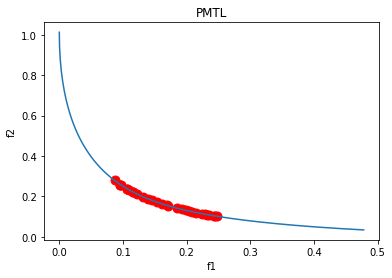

CPU times: user 4min 4s, sys: 3.48 s, total: 4min 7s
Wall time: 4min 16s


In [ ]:
%%time
# use autograd to calculate the gradient
import autograd.numpy as np
from autograd import grad
from math import e
from matplotlib import pyplot as plt


def get_d_paretomtl(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
    
    
    # solve QP 
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0
   
    vec =  np.concatenate((grads, np.dot(w[idx],grads)), axis = 0)
    
    # use MinNormSolver to solve QP
    sol, nd = MinNormSolver.find_min_norm_element(vec)
   
    
    # reformulate ParetoMTL as linear scalarization method, return the weights
    weight0 =  sol[0] + np.sum(np.array([sol[j] * w[idx][j - 2,0] for j in np.arange(2,2 + np.sum(idx))]))
    weight1 = sol[1] + np.sum(np.array([sol[j] * w[idx][j - 2,1] for j in np.arange(2,2 + np.sum(idx))]))
    weight = np.stack([weight0,weight1])
   
    return weight


def get_d_paretomtl_init(grads,value,weights,i):
    # calculate the gradient direction for Pareto MTL initialization
    nobj, dim = grads.shape
    
    # check active constraints
    normalized_current_weight = weights[i]/np.linalg.norm(weights[i])
    normalized_rest_weights = np.delete(weights, (i), axis=0) / np.linalg.norm(np.delete(weights, (i), axis=0), axis = 1,keepdims = True)
    w = normalized_rest_weights - normalized_current_weight
    
    gx =  np.dot(w,value/np.linalg.norm(value))
    idx = gx >  0
    
    if np.sum(idx) <= 0:
        return np.zeros(nobj)
    if np.sum(idx) == 1:
        sol = np.ones(1)
    else:
        vec =  np.dot(w[idx],grads)
        sol, nd = MinNormSolver.find_min_norm_element(vec)

    # calculate the weights
    weight0 =  np.sum(np.array([sol[j] * w[idx][j ,0] for j in np.arange(0, np.sum(idx))]))
    weight1 =  np.sum(np.array([sol[j] * w[idx][j ,1] for j in np.arange(0, np.sum(idx))]))
    weight = np.stack([weight0,weight1])
   

    return weight


# def circle_points(r, n):
#     # generate evenly distributed preference vector
#     circles = []
#     for r, n in zip(r, n):
#         t = np.linspace(0, 0.5 * np.pi, n)
#         x = r * np.cos(t)
#         y = r * np.sin(t)
#         circles.append(np.c_[x, y])
#     return circles

def circle_points(K, min_angle=None, max_angle=None):
    # generate evenly distributed preference vector
    ang0 = np.pi / 20. if min_angle is None else min_angle
    ang1 = np.pi * 9 / 20. if max_angle is None else max_angle
    angles = np.linspace(ang0, ang1, K, endpoint=True)
    x = np.cos(angles)
    y = np.sin(angles)
    return np.c_[x, y]

### the synthetic multi-objective problem ###
def f1(x):
    
    n = len(x)
    
    sum1 = np.sum([(x[i] - 1.0/np.sqrt(n)) ** 2 for i in range(n)])

    f1 = 1 - e**(- sum1)
    return f1

def f2(x):
    
    n = len(x)
    
    sum2 = np.sum([(x[i] + 1.0/np.sqrt(n)) ** 2 for i in range(n)])
   
    f2 = 1 - e**(- sum2)
    
    return f2

def f3(x):
    #2 dims
    return 1/25*x[0]**2+1/100*(x[1]-9/2)**2
def f4(x):
    return 1/25*x[1]**2+1/100*(x[0]-9/2)**2

# calculate the gradients using autograd
f1_dx = grad(f1)
f2_dx = grad(f2)
f3_dx = grad(f3)
f4_dx = grad(f4)

def concave_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f1(x), f2(x)]), np.stack([f1_dx(x), f2_dx(x)])
    
def convex_fun_eval(x):
    """
    return the function values and gradient values
    """
    return np.stack([f3(x), f4(x)]), np.stack([f3_dx(x), f4_dx(x)])

### create the ground truth Pareto front ###
def create_pf_concave():
    ps = np.linspace(-1/np.sqrt(2),1/np.sqrt(2))
    pf = []
    
    for x1 in ps:
        #generate solutions on the Pareto front:
        x = np.array([x1,x1])
        
        f, f_dx = concave_fun_eval(x)
        pf.append(f)
            
    pf = np.array(pf)
    
    return pf


def create_pf1():
    ps1 = np.linspace(-6, 0, num=500)
    pf = []
    for x1 in ps1:
        x = [9*x1/(2*x1-8),9/(2-8*x1)]
        f = [f3(x), f4(x)]
        #print(f)
        pf.append(f)
    pf = np.array(pf)
    return pf

def pareto_mtl_search(ref_vecs,i,t_iter = 1000, n_dim = 2, step_size = 1):
    """
    Pareto MTL
    """

    # randomly generate one solution
    x = np.random.uniform(-0.5,0.5,n_dim)
    #x = (np.random.rand(1,2)).tolist()[0]
    #x = np.random.uniform(-2,0,n_dim)
    #print(x.shape)
    # find the initial solution
    for t in range(int(t_iter * 0.2)):
        #f, f_dx = concave_fun_eval(x)
        f, f_dx = convex_fun_eval(x)

        weights =  get_d_paretomtl_init(f_dx,f,ref_vecs,i)
     
        x = x - step_size * np.dot(weights.T,f_dx).flatten()

    # find the Pareto optimal solution
    for t in range(int(t_iter * 0.8)):
        f, f_dx = convex_fun_eval(x)
        #f, f_dx = concave_fun_eval(x)

        weights =  get_d_paretomtl(f_dx,f,ref_vecs,i)
     
        direction_descent = -np.dot(weights.T,f_dx).flatten()

        x = x + step_size * direction_descent

    return x, f




def run(num = 30):
    """
    run method on the synthetic example
    method: optimization method {'ParetoMTL', 'MOOMTL', 'Linear'}
    num: number of solutions
    """
    
    #pf = create_pf_concave()
    pf = create_pf1()
    f_value_list = []
    
    weights = circle_points(num)
    
    for i in range(num):
        
        print(i)
        
        x, f = pareto_mtl_search(ref_vecs = weights,i = i)
        
        f_value_list.append(f)
        
    f_value = np.array(f_value_list)
    hv = Hypervolume(ref_point=np.array([1, 1]))
    print('Hyper volume: ',hv(f_value))
    plt.plot(pf[:,0],pf[:,1])
    plt.scatter(f_value[:,0], f_value[:,1], c = 'r', s = 80)
    plt.xlabel("f1")
    plt.ylabel("f2")
    plt.title("PMTL")
    plt.show()
    
run()